# **Pakistan Stock Exchange (KSE 100)**

In [81]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import requests
from io import StringIO
import joblib
import pickle

In [82]:
# Fetch the CSV data
url = "https://hebbkx1anhila5yf.public.blob.vercel-storage.com/Stock%20Exchange%20KSE%20100(Pakistan)-CVOfJDc05PO5SeRDlJAfIDUEtJpefw.csv"
response = requests.get(url)
csv_content = StringIO(response.text)

In [83]:
# Load the data
df = pd.read_csv(csv_content, parse_dates=['Date'])
df.head()

<ipython-input-83-774cd43494d7>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(csv_content, parse_dates=['Date'])


,Date,Open,High,Low,Close,Change,Volume
0,2021-02-23,"31,722.16","31,800.90","31,597.31","31,626.19",-21.38,"718,191,025"
1,2021-02-22,"31,874.78","31,958.58","31,612.55","31,647.57",-203.61,"721,952,658"
2,2021-02-19,"31,748.75","31,904.30","31,749.43","31,851.18",91.36,"694,795,084"
3,2021-02-18,"32,049.85","32,104.67","31,745.72","31,759.82",-288.86,"577,837,595"
4,2021-02-17,"32,166.21","32,390.77","32,044.01","32,048.68",-93.15,"701,658,181"


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3221 entries, 0 to 3220
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3221 non-null   datetime64[ns]
 1   Open    3221 non-null   object        
 2   High    3221 non-null   object        
 3   Low     3221 non-null   object        
 4   Close   3221 non-null   object        
 5   Change  3221 non-null   object        
 6   Volume  3221 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 176.3+ KB


In [85]:
# Preprocess the data
df['Open'] = df['Open'].str.replace(',', '').astype(float)
df['High'] = df['High'].str.replace(',', '').astype(float)
df['Low'] = df['Low'].str.replace(',', '').astype(float)
df['Close'] = df['Close'].str.replace(',', '').astype(float)
df['Change'] = df['Change'].str.replace(',', '').astype(float)
df['Volume'] = df['Volume'].str.replace(',', '').astype(float)

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3221 entries, 0 to 3220
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3221 non-null   datetime64[ns]
 1   Open    3221 non-null   float64       
 2   High    3221 non-null   float64       
 3   Low     3221 non-null   float64       
 4   Close   3221 non-null   float64       
 5   Change  3221 non-null   float64       
 6   Volume  3221 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 176.3 KB


In [87]:
summary = df[['Open', 'High', 'Low', 'Close', 'Change', 'Volume']].describe()
summary

,Open,High,Low,Close,Change,Volume
count,3221.000000,3221.000000,3221.000000,3221.000000,3221.000000,3.221000e+03
mean,18806.389208,18913.961723,18694.557457,18801.652980,6.662738,2.006365e+08
std,9556.736989,9599.905455,9502.488358,9550.963841,288.333717,1.348805e+08
min,3634.560000,3742.310000,3623.350000,3647.100000,-8060.960000,-1.525267e+08
25%,8418.150000,8479.860000,8348.880000,8426.350000,-68.460000,1.120844e+08
50%,21777.350000,21885.330000,21640.080000,21771.630000,6.330000,1.702730e+08
75%,27911.000000,28108.020000,27656.070000,27895.150000,95.560000,2.543143e+08
max,36317.920000,36389.500000,36132.760000,36234.200000,7957.090000,1.124724e+09


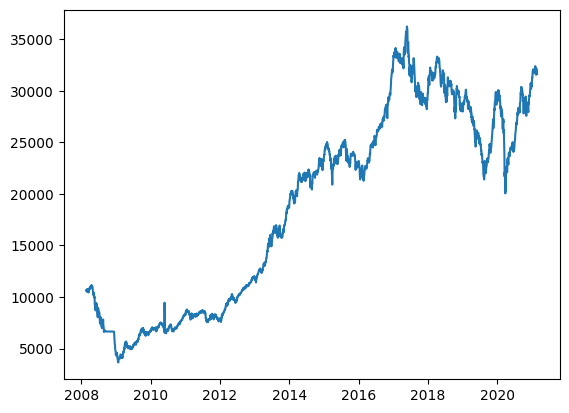

In [88]:
xpoints = df['Date']
ypoints = df['Close']
plt.plot(xpoints, ypoints)
plt.show()

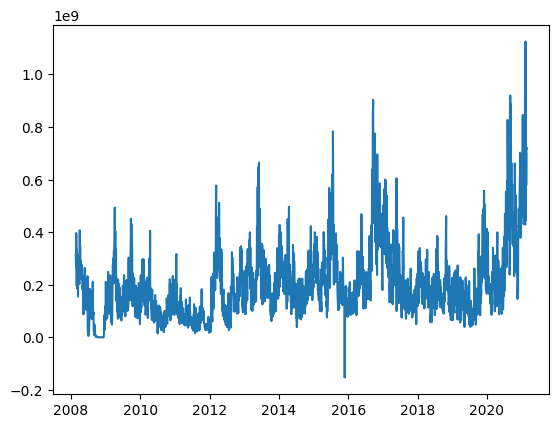

In [89]:
xaxis = df['Date']
yaxis = df['Volume']
plt.plot(xaxis, yaxis)
plt.show()

In [90]:
# Sort by date
df = df.sort_values('Date')

In [91]:
# Select features for prediction
features = ['Open', 'High', 'Low', 'Close', 'Volume']
target = 'Close'

In [92]:
# Normalize the features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

In [94]:
# Create sequences for time series prediction
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = 10  # Number of previous days to use for prediction
X, y = create_sequences(df[features].values, sequence_length)

In [96]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [119]:
# Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, len(features)), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(len(features))
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [120]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1144 - val_loss: 0.0027
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0121 - val_loss: 0.0025
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0088 - val_loss: 0.0039
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0078 - val_loss: 0.0015
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0068 - val_loss: 0.0017
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0059 - val_loss: 0.0010
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0059 - val_loss: 0.0011
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0052 - val_loss: 0.0014
Epoch 9/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0050 - val_loss: 9.3693e-04
Epoch 10/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0049 - val_loss: 9.5152e-04
Epoch 11/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0043 - val_loss: 9.4797e-04
Epoch 12/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0

In [121]:
# Evaluate the model
mse = model.evaluate(X_test, y_test, verbose=0)
print(f"Mean Squared Error on test set: {mse}")

Mean Squared Error on test set: 0.0006103041814640164


In [122]:
# Make predictions
y_pred = model.predict(X_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [123]:
# Inverse transform the predictions and actual values
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

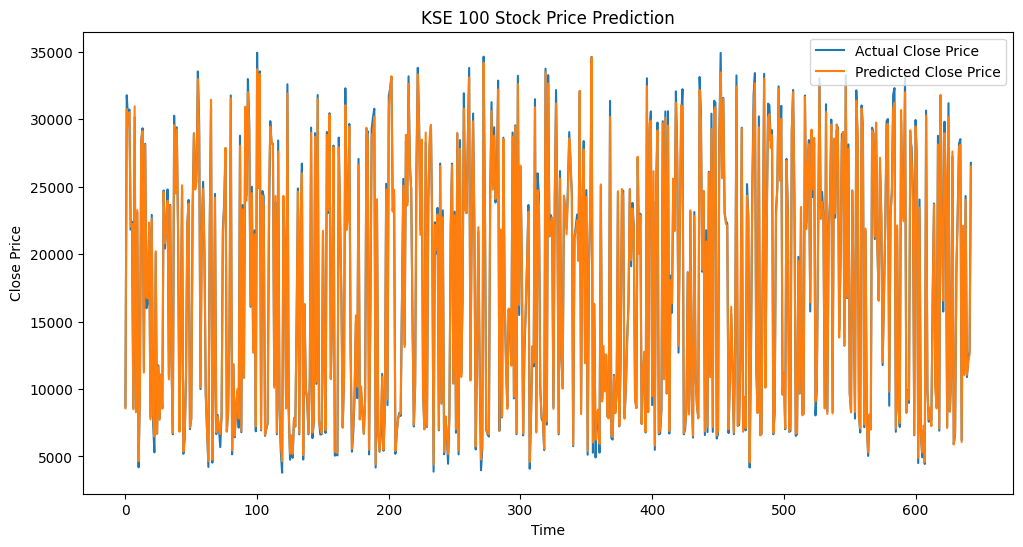

In [124]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv[:, 3], label='Actual Close Price')
plt.plot(y_pred_inv[:, 3], label='Predicted Close Price')
plt.title('KSE 100 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [125]:
# Calculate and print the Root Mean Squared Error (RMSE)
rmse = np.sqrt(np.mean((y_test_inv[:, 3] - y_pred_inv[:, 3])**2))
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 459.6844426599826


In [126]:
# Print example predictions
print("\nExample Predictions:")
for i in range(5):
    print(f"Actual: {y_test_inv[i, 3]:.2f}, Predicted: {y_pred_inv[i, 3]:.2f}")


Example Predictions:
Actual: 8694.33, Predicted: 8568.69
Actual: 31778.82, Predicted: 30754.89
Actual: 30065.22, Predicted: 29499.95
Actual: 30723.19, Predicted: 30518.96
Actual: 21810.03, Predicted: 22064.69


In [127]:
# Save the model
model.save('kse100_stock_prediction_model.h5')
print("\nModel saved as 'kse100_stock_prediction_model.h5'")


Model saved as 'kse100_stock_prediction_model.h5'


In [128]:
# Save the trained model
joblib.dump(model, "Stock Exchange.pkl")

['Stock Exchange.pkl']

In [129]:
loaded_model = joblib.load("Stock Exchange.pkl")
print(loaded_model)  # Ensure the model loads correctly


<Sequential name=sequential_12, built=True>


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [130]:
print(model.input_shape)  # This will show the expected input shape


(None, 10, 5)


**Apply the model predicts whether the stock price will Increase or Decrease:**

In [131]:
# Step 1: Load the trained model
model_filename = "Stock Exchange.pkl"  # Ensure this file exists
with open(model_filename, "rb") as file:
    model = pickle.load(file)


In [132]:
# Step 2: Provide input data (Ensure correct shape)
input_data = np.array([
    [100.5, 105.3, 98.7, 500000, 1],
    [101.0, 106.0, 99.0, 520000, 1],
    [102.2, 107.5, 100.3, 530000, 1],
    [103.0, 108.0, 101.0, 540000, 1],
    [104.1, 109.2, 102.5, 550000, 1],
    [105.5, 110.0, 103.8, 560000, 1],
    [106.8, 111.3, 105.0, 570000, 1],
    [107.5, 112.0, 106.0, 580000, 1],
    [108.9, 113.2, 107.4, 590000, 1],
    [109.3, 114.0, 108.0, 600000, 1]
])

In [133]:
# Reshape for model (batch_size, time_steps, features)
input_data = input_data.reshape(1, 10, 5)  # Adjust this to match your model input

In [134]:
# Step 3: Make a prediction
prediction = model.predict(input_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


In [135]:
# Step 4: Convert the prediction output properly
predicted_label = int(prediction[0][0])  # Extract a single scalar value

In [136]:
# Step 5: Display the result
print("Predicted Stock Movement:", "Increase" if predicted_label == 1 else "Decrease")

Predicted Stock Movement: Decrease
